# Interactive Portfolio Risk and Return Analysis

In this notebook, we'll explore the concepts of portfolio risk and return using Python. We'll use real stock data to calculate key metrics and visualize our findings at each step. This analysis will help us understand how to construct and evaluate investment portfolios.

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from scipy import stats
import yfinance as yf

# Set plot style
plt.style.use('seaborn-v0_8') # You can check available styles by executing: plt.style.available
sns.set_palette("pastel")

## Steps we'll cover:
1. Data Collection
2. Return Calculation
3. Portfolio Return
4. Portfolio Risk
5. Efficient Frontier
6. Sharpe Ratio Optimization

Let's begin!

## 1. Data Collection

First, we'll collect historical price data for a selection of stocks. We'll use the `yfinance` library to fetch data from Yahoo Finance.

In [4]:
# Define the list of stocks and date range
stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'CVX']
start_date = '2018-01-01'
end_date = '2023-12-31'

# Fetch the data
data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']

# Display the first few rows of the data
data.head()

[*********************100%***********************]  5 of 5 completed


Ticker                          AAPL       AMZN        CVX      GOOGL  \
Date                                                                    
2018-01-02 00:00:00+00:00  40.568913  59.450500  95.478844  53.527958   
2018-01-03 00:00:00+00:00  40.561871  60.209999  96.174843  54.441196   
2018-01-04 00:00:00+00:00  40.750271  60.479500  95.875511  54.652668   
2018-01-05 00:00:00+00:00  41.214222  61.457001  95.718346  55.377377   
2018-01-08 00:00:00+00:00  41.061150  62.343498  96.189827  55.572891   

Ticker                          MSFT  
Date                                  
2018-01-02 00:00:00+00:00  79.792923  
2018-01-03 00:00:00+00:00  80.164268  
2018-01-04 00:00:00+00:00  80.869827  
2018-01-05 00:00:00+00:00  81.872452  
2018-01-08 00:00:00+00:00  81.956017

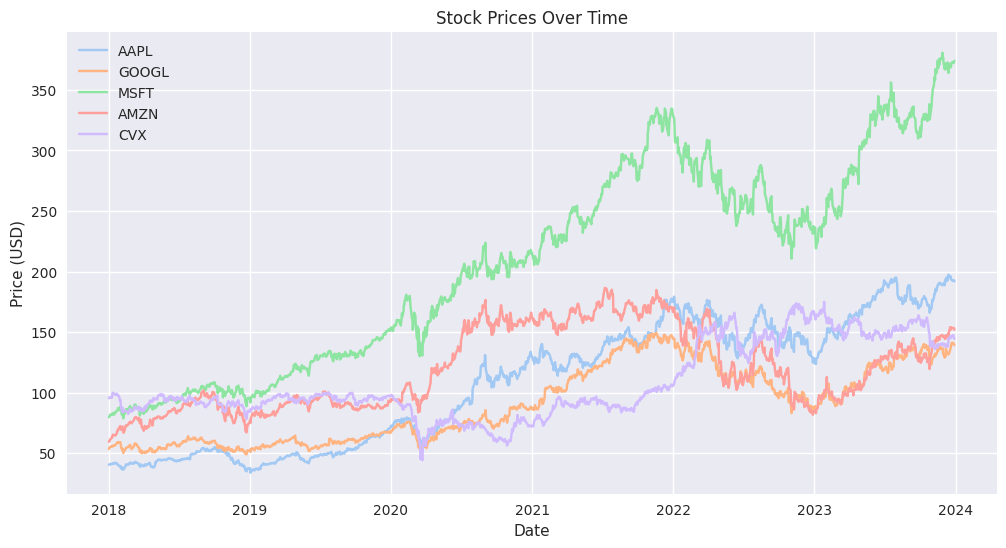

In [6]:
# Visualize the stock prices
plt.figure(figsize=(12, 6))
for stock in stocks:
    plt.plot(data.index, data[stock], label=stock)
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

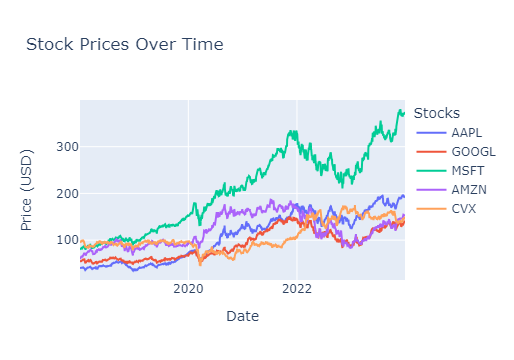

In [8]:
# Visualize the stock prices using Plotly
fig = go.Figure()
for stock in stocks:
    fig.add_trace(go.Scatter(x=data.index, y=data[stock], mode='lines', name=stock))
fig.update_layout(title='Stock Prices Over Time',
                  xaxis_title='Date',
                  yaxis_title='Price (USD)',
                  legend_title='Stocks')
fig.show()

## 2. Return Calculation

Now that we have our price data, let's calculate the daily returns for each stock. We'll use logarithmic returns, which are preferred in financial analysis for their additive property.

In [10]:
# Calculate daily returns
returns = np.log(data / data.shift(1))

# Display the first few rows of returns
returns.head()

Ticker                         AAPL      AMZN       CVX     GOOGL      MSFT
Date                                                                       
2018-01-02 00:00:00+00:00       NaN       NaN       NaN       NaN       NaN
2018-01-03 00:00:00+00:00 -0.000174  0.012694  0.007263  0.016917  0.004643
2018-01-04 00:00:00+00:00  0.004634  0.004466 -0.003117  0.003877  0.008763
2018-01-05 00:00:00+00:00  0.011321  0.016033 -0.001641  0.013173  0.012322
2018-01-08 00:00:00+00:00 -0.003721  0.014322  0.004914  0.003524  0.001020

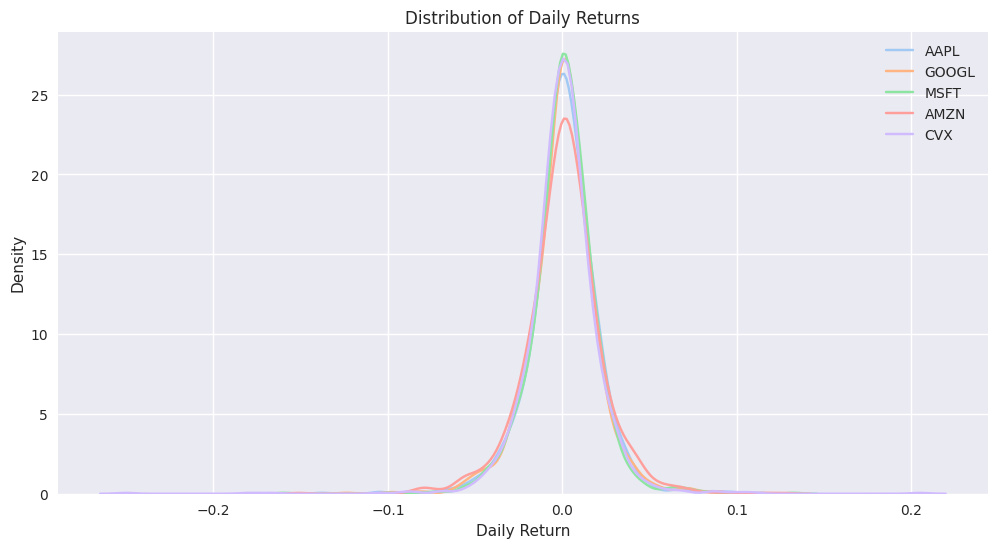

In [12]:
# Visualize the returns distribution
plt.figure(figsize=(12, 6))
for stock in stocks:
    sns.kdeplot(returns[stock].dropna(), label=stock)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.legend()
plt.show()

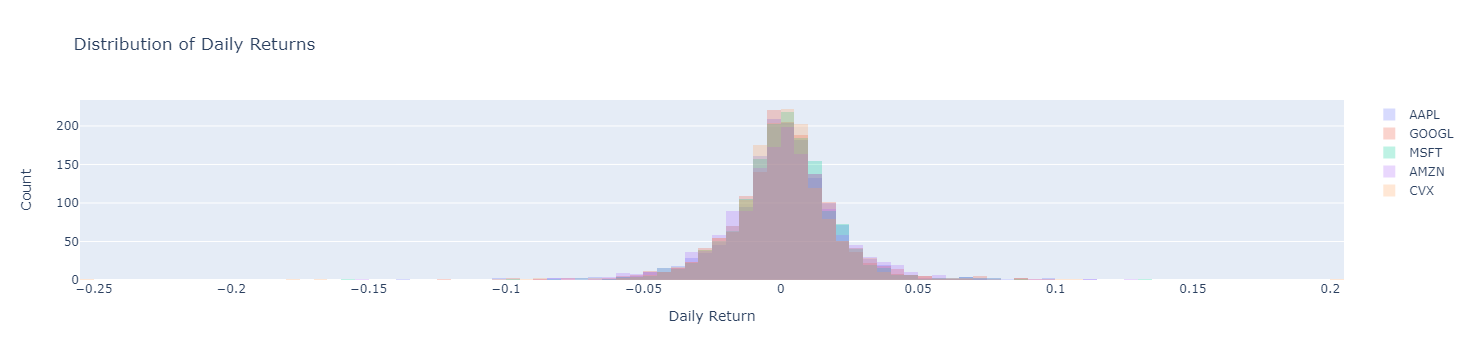

In [22]:
# Visualize the returns distribution using Plotly
fig = go.Figure()
for stock in stocks:
    fig.add_trace(go.Histogram(x=returns[stock].dropna(), name=stock, opacity=0.25, nbinsx=100))
fig.update_layout(title='Distribution of Daily Returns',
                  xaxis_title='Daily Return',
                  yaxis_title='Count',
                  barmode='overlay')
fig.show()

## 3. Portfolio Return

Now let's calculate the expected return of a portfolio. We'll start with an equally weighted portfolio and then explore how changing weights affects the overall return.

In [24]:
# Calculate average daily returns and covariance
avg_returns = returns.mean()
cov_matrix = returns.cov()

# Function to calculate portfolio return
def portfolio_return(weights, avg_returns):
    return np.sum(avg_returns * weights)

# Equal weights
n_assets = len(stocks)
weights_equal = np.array([1/n_assets] * n_assets)

# Calculate portfolio return
port_return_equal = portfolio_return(weights_equal, avg_returns)

print(f"Expected Daily Return (Equal Weights): {port_return_equal:.6f}")
print(f"Expected Annual Return (Equal Weights): {(port_return_equal * 252):.4f}")

Expected Daily Return (Equal Weights): 0.000717
Expected Annual Return (Equal Weights): 0.1807


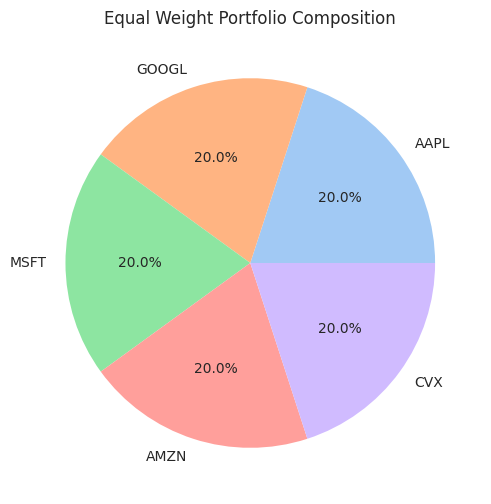

In [26]:
# Visualize portfolio weights
plt.figure(figsize=(10, 6))
plt.pie(weights_equal, labels=stocks, autopct='%1.1f%%')
plt.title('Equal Weight Portfolio Composition')
plt.show()

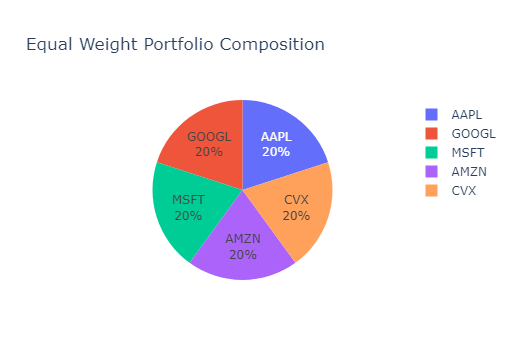

In [28]:
# Visualize portfolio weights using Plotly
fig = go.Figure(data=[go.Pie(labels=stocks, values=weights_equal, textinfo='label+percent')])
fig.update_layout(title='Equal Weight Portfolio Composition')
fig.show()

## 4. Portfolio Risk

Next, we'll calculate the portfolio risk, which is measured by the standard deviation of portfolio returns. We'll use the covariance matrix to account for the relationships between asset returns.

In [30]:
# Function to calculate portfolio volatility
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Calculate portfolio volatility
port_volatility_equal = portfolio_volatility(weights_equal, cov_matrix)

print(f"Daily Volatility (Equal Weights): {port_volatility_equal:.6f}")
print(f"Annual Volatility (Equal Weights): {(port_volatility_equal * np.sqrt(252)):.4f}")

# Visualize risk contribution
risk_contribution = np.multiply(weights_equal, np.dot(cov_matrix, weights_equal)) / portfolio_volatility(weights_equal, cov_matrix)**2

Daily Volatility (Equal Weights): 0.016308
Annual Volatility (Equal Weights): 0.2589


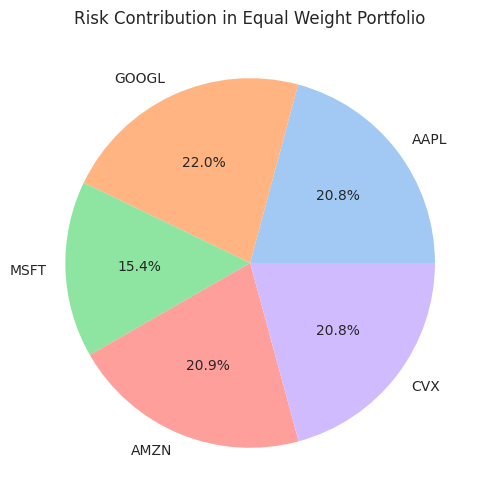

In [32]:
plt.figure(figsize=(10, 6))
plt.pie(risk_contribution, labels=stocks, autopct='%1.1f%%')
plt.title('Risk Contribution in Equal Weight Portfolio')
plt.show()

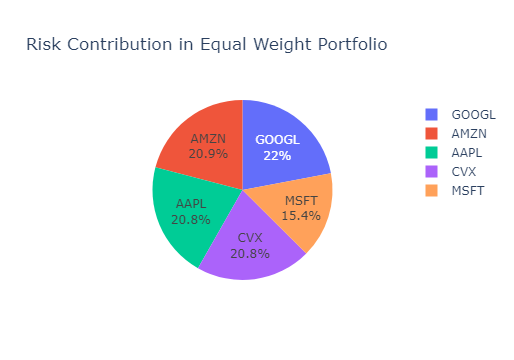

In [34]:
# Visualize risk contribution using Plotly
fig = go.Figure(data=[go.Pie(labels=stocks, values=risk_contribution, textinfo='label+percent')])
fig.update_layout(title='Risk Contribution in Equal Weight Portfolio')
fig.show()

## 5. Efficient Frontier

The efficient frontier represents the set of optimal portfolios that offer the highest expected return for a defined level of risk. Let's calculate and visualize the efficient frontier for our portfolio.

In [36]:
# Function to generate random portfolios
def random_portfolios(num_portfolios, avg_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(avg_returns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_ret = portfolio_return(weights, avg_returns)
        portfolio_std_dev = portfolio_volatility(weights, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_ret
        results[2,i] = (portfolio_ret - risk_free_rate) / portfolio_std_dev
    return results, weights_record

# Generate random portfolios
num_portfolios = 10000
risk_free_rate = 0.01  # Assuming 1% risk-free rate

results, weights = random_portfolios(num_portfolios, avg_returns, cov_matrix, risk_free_rate)

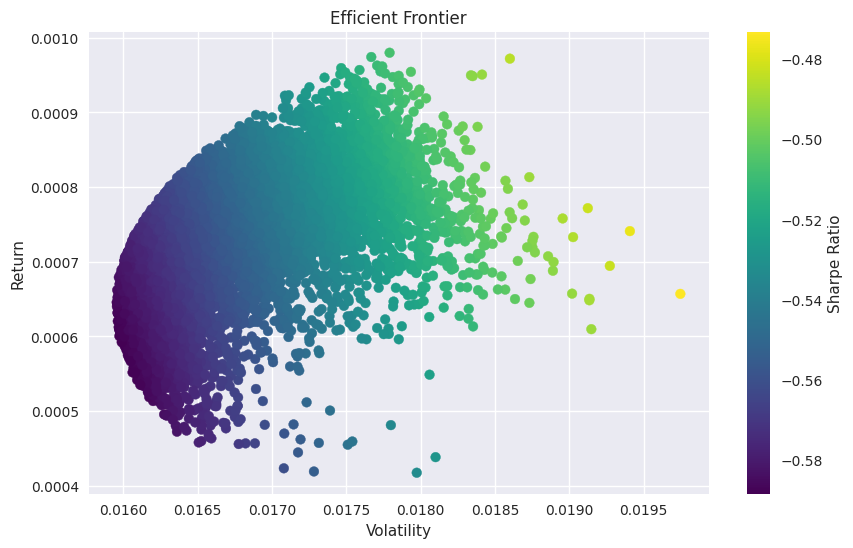

In [38]:
# Plot efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.show()

Let's use Plotly, but also change the x- and y-axis scale from daily risk and return values, to annualized: 

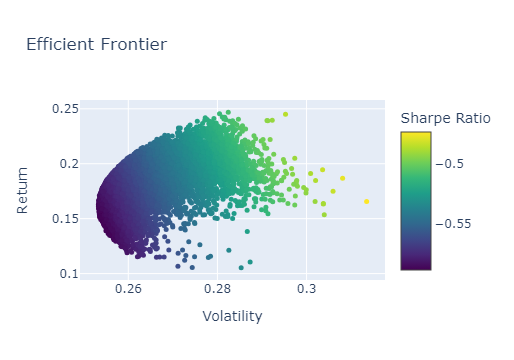

In [42]:
# Plot efficient frontier using Plotly
fig = go.Figure()
scatter = go.Scatter(
    x=results[0,:]*np.sqrt(252), # annualizing volatility
    y=results[1,:]*252, # annualizing returns
    mode='markers',
    marker=dict(
        size=5,
        color=results[2,:],  # set color to Sharpe Ratio
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title='Sharpe Ratio')
    )
)
fig.add_trace(scatter)
fig.update_layout(title='Efficient Frontier',
                  xaxis_title='Volatility',
                  yaxis_title='Return')
fig.show()

## 6. Sharpe Ratio Optimization

Finally, let's find the portfolio with the highest Sharpe ratio, which represents the best risk-adjusted return.

In [45]:
# Find the portfolio with the highest Sharpe Ratio
max_sharpe_idx = np.argmax(results[2])
sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx], index=stocks, columns=['allocation'])
max_sharpe_allocation.allocation = [round(i*100,2) for i in max_sharpe_allocation.allocation]

print("Optimal Portfolio Allocation (Highest Sharpe Ratio):")
print(max_sharpe_allocation)
print(f"Expected Annual Return: {rp*252:.4f}")
print(f"Annual Volatility: {sdp*np.sqrt(252):.4f}")
print(f"Sharpe Ratio: {results[2,max_sharpe_idx]:.4f}")

Optimal Portfolio Allocation (Highest Sharpe Ratio):
       allocation
AAPL         4.23
GOOGL       69.01
MSFT         1.08
AMZN        21.01
CVX          4.66
Expected Annual Return: 0.1656
Annual Volatility: 0.3135
Sharpe Ratio: -0.4731


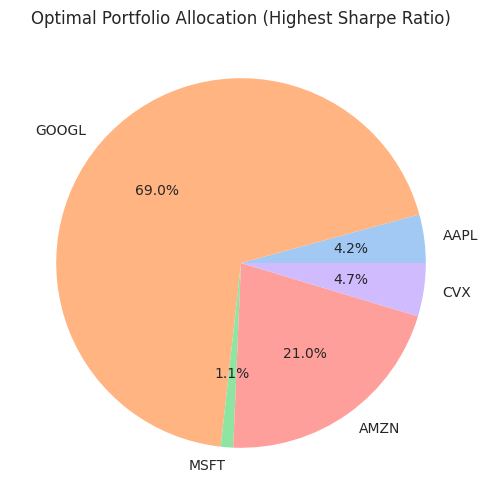

In [47]:
# Visualize optimal portfolio allocation
plt.figure(figsize=(10, 6))
plt.pie(max_sharpe_allocation['allocation'], labels=max_sharpe_allocation.index, autopct='%1.1f%%')
plt.title('Optimal Portfolio Allocation (Highest Sharpe Ratio)')
plt.show()

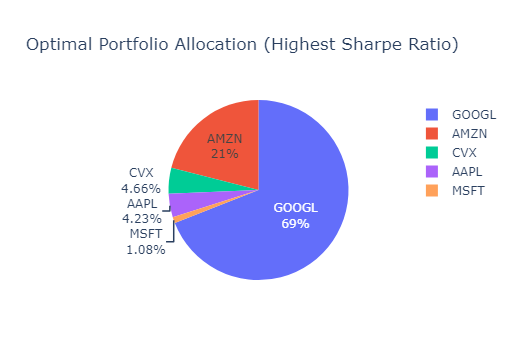

In [49]:
# Visualize optimal portfolio allocation using Plotly
fig = go.Figure(data=[go.Pie(labels=max_sharpe_allocation.index, values=max_sharpe_allocation['allocation'], textinfo='label+percent')])
fig.update_layout(title='Optimal Portfolio Allocation (Highest Sharpe Ratio)')
fig.show()

## Conclusion

In this interactive example, we've walked through the process of portfolio risk and return analysis using Python. We've covered data collection, return calculation, portfolio return and risk computation, efficient frontier visualization, and Sharpe ratio optimization.

This analysis provides valuable insights into portfolio construction and evaluation, demonstrating how diversification and optimal asset allocation can help balance risk and return in investment portfolios.

Remember that past performance doesn't guarantee future results, and this analysis should be considered as an educational example rather than investment advice.